In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import re 
import nltk
import emoji

import string
import unicodedata
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spellchecker import SpellChecker
from nltk.tokenize import sent_tokenize, word_tokenize
from langid.langid import LanguageIdentifier, model
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
import scattertext as st


In [215]:
file_path = '../../Downloads/concatenated_abridged.jsonl'

In [38]:
#Reading in the json file

with open(file_path, 'r') as json_file:
    json_strings = list(json_file)
json_list = []
for tweet in json_strings:
    json_list.append(json.loads(tweet))
df = pd.DataFrame(json_list)

In [162]:
# Creating a copy of the dataframe to work off of 
tweet_df = df.copy()

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140337 entries, 0 to 140336
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   created_at          140337 non-null  object
 1   id                  140337 non-null  int64 
 2   full_text           140337 non-null  object
 3   display_text_range  140337 non-null  object
 4   entities            140337 non-null  object
 5   user                140337 non-null  object
 6   retweet_count       140337 non-null  int64 
 7   favorite_count      140337 non-null  int64 
 8   favorited           140337 non-null  bool  
 9   retweeted           140337 non-null  bool  
 10  lang                140337 non-null  object
dtypes: bool(2), int64(3), object(6)
memory usage: 9.9+ MB


In [164]:
#Selecting columns I want to work with
tweet_df = tweet_df[['created_at', 'id','full_text','display_text_range','entities','user', 'retweet_count', 'favorite_count','favorited','retweeted','lang']]

In [165]:
# Extracting username from the user's profile information
tweet_df['user_description'] = tweet_df.user.apply(lambda x: x['description'])

tweet_df = tweet_df[['created_at', 'id','user_description','full_text','display_text_range','entities','user', 'retweet_count', 'favorite_count','lang']]

In [166]:
# Grabbing the value that depicts the length of the tweet.
tweet_df.display_text_range = tweet_df.display_text_range.apply(lambda x: x[-1])

In [167]:
# Renaming columns to provide a better description of each column's contents
tweet_df.columns =['created_at', 'id','user_description','full_text','tweet_length','entities','user', 'retweet_count', 'favorite_count','lang']

In [168]:
# Converting created_at to date time
tweet_df.created_at = pd.to_datetime(tweet_df.created_at)

In [169]:
tweet_df.head()

,created_at,id,user_description,full_text,tweet_length,entities,user,retweet_count,favorite_count,lang
0,2020-09-29 23:59:56+00:00,1311093385688735744,Conservative/#MAGA/ #WWG1WGA /MbrNRA/#Trump202...,Biden a professional debater?? Hardly!! More ...,71,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 117904481, 'id_str': '117904481', 'name...",0,0,en
1,2020-09-29 23:59:58+00:00,1311093394400333824,Canadian 🇨🇦 Windmill Cancer Survivor. I follow...,RT @DarDar458: #PresidentialDebate #Debates202...,73,"{'hashtags': [{'text': 'PresidentialDebate', '...","{'id': 30140760, 'id_str': '30140760', 'name':...",1,0,und
2,2020-09-30 00:00:00+00:00,1311093401652277252,Airing Weekdays at 9AM ET on the Fox Business ...,How can Biden stand a chance against Trump in ...,280,"{'hashtags': [{'text': 'VarneyCo', 'indices': ...","{'id': 281610530, 'id_str': '281610530', 'name...",25,100,en
3,2020-09-30 00:00:02+00:00,1311093410737070086,Politics reporter covering elections & voting ...,RT @abbydphillip: Very reminiscent of pre-2018...,108,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 88223320, 'id_str': '88223320', 'name':...",351,0,en
4,2020-09-30 00:00:04+00:00,1311093419100561408,"wife, mother, grandmother, southerner, conserv...",RT @RudyGiuliani: Why was Corrupt Biden’s son ...,110,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 44295160, 'id_str': '44295160', 'name':...",15672,0,en


In [170]:
def preprocess_text_hastag(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Removes links, special characters and other bulk cleaning
    2. Returns a list of the tidy text
    """
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [171]:
tweet_df.full_text = tweet_df.full_text.apply(lambda x: preprocess_text(x))

In [174]:
tweet_df.user_description = tweet_df.user_description.apply(lambda x: preprocess_text(x))

In [125]:
biden_hashtags = []

for i in biden_df.full_text:
    for j in i.split():
        if '#' in j:
            biden_hashtags.append(j)
    

In [130]:
biden_hashtags_full = " ".join([text for text in biden_hashtags])

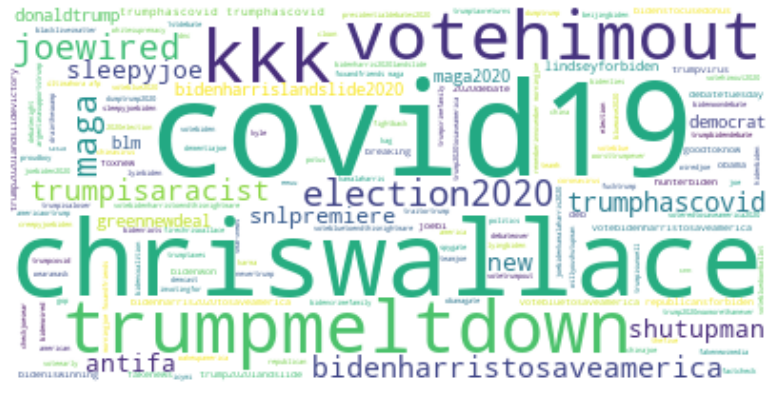

In [324]:
fig, ax = plt.subplots(figsize = (14, 7))

stopwords = ['joebiden','bidenharris2020','debates2020','biden','presidentialdebate','presidentialdebate2020',
             'debate','debate2020','bidenharris','votebidenharris2020','biden2020','trump','trump2020','bidenwonthedebate',
            'debates','vote']
wordcloud = WordCloud(stopwords = stopwords,background_color="white").generate(biden_hashtags_full)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [127]:
trump_hashtags = []

for i in trump_df.full_text:
    for j in i.split():
        if '#' in j:
            trump_hashtags.append(j)

In [134]:
trump_hashtags_full = " ".join([text for text in trump_hashtags])

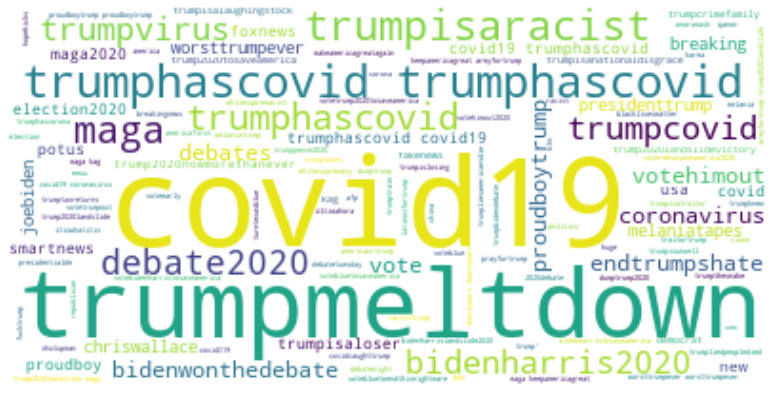

In [149]:
fig, ax = plt.subplots(figsize = (14, 7))


stopwords = ['trump','trump2020','debates2020','debate','donaldtrump','presidentialdebate',
             'presidentialdebate2020','bidenharris','votebidenharris2020','biden2020','biden']
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(trump_hashtags_full)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [207]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis(text):
    return sentiment_analyzer.polarity_scores(text)['compound']

sentiment_analysis('I love it!')

0.6696

In [208]:
trump_df['tweet_sentiment'] = trump_df.full_text.apply(lambda x: sentiment_analysis(x))

/Users/zacharyvillarreal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [221]:
president_mentioned = []
for i in tweet_df.full_text:
    if (('donald' in i.lower()) and ('biden' in i.lower())) or (('donald' in i.lower()) and ('joe' in i.lower())) or \
        (('trump' in i.lower()) and ('biden' in i.lower())) or (('trump' in i.lower()) and ('joe' in i.lower())):
            president_mentioned.append('trump and biden')
    elif ('donald' in i.lower()) or ('trump' in i.lower()) or ('donaldtrump' in i.lower()):
        president_mentioned.append('trump')
    elif ('biden' in i.lower()) or ('joe' in i.lower()) or ('joebiden' in i.lower()):
        president_mentioned.append('biden')
    else:
        president_mentioned.append('no_candidate')


In [223]:
tweet_df['president_mentioned'] = president_mentioned

In [234]:
def lowercase(doc):
    '''
    lowercase: takes in a string and lowercases it
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python strin converted to lowercase
    '''
    doc = doc.lower()
    return doc


def remove_punctuation(doc):
    '''
    remove_punctuation: takes in a string and 
    revoes the punctuation via RegEx
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python string with punctuation removed
    '''
    return re.sub(r'[^\w\s]','',doc)



def remove_html(doc):
    '''
    remove_url: takes in a string and removes
    html values '<.X?>' using RegEx
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python string with removed html text
    '''
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'',doc)

def remove_url(doc):
    '''
    remove_url: takes in a string and removes
    url values 'https://, etc.' using RegEx
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python string with removed url text
    '''
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r'', doc)

def convert_emoticons(doc):
    '''
    convert_emoticons: takes in a string and converts
    emoticons ':), :(, :-), etc.' with word values.
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python string with converted emoticons
    '''
    for i in EMOTICONS:
        doc = re.sub(u'('+i+')', "_".join(EMOTICONS[i].replace(",","").split()), doc)
    return doc

def convert_emojis(doc):
    '''
    convert_emojis: takes in a string and converts
    emojis '😀, 😂, etc.' with word values.
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python string with converted emojis
    '''
    doc = emoji.demojize(doc)
    doc = re.sub('[:]', '', doc)
    return doc

def convert_text_speech(doc):
    '''
    convert_text_speech: takes in a string and converts any
    abbreviated text speech, 'ttyl, imo, wtf, etc.' and converts
    it into its component words
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python string with converted text speech
    '''
    text = []
    #removes punctuation because that throws off the conversion
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    for i in doc.split():
        if i.upper() in chat_list:
            text.append(chat_dict[i.upper()])
        else:
            text.append(i)
    return " ".join(text)


def remove_stopwords(doc):
    '''
    remove_stopwords: takes in a list of strings removes
    those strings that contain stopwords imported from the 
    nlkt.corpus library
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python list with stop words removed
    '''
    doc = [word for word in doc if word not in sw]
    return doc

def set_english(df, text_column):
    '''
    set_english: takes in a string of a text column
    outputs the predicted languge of that string to a list
    which is used to mask a pandas DataFrame.
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python list with predicted language
    '''
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)  
    lst =[]
    for i in df[text_column].values: 
        lang, score = identifier.classify(i)
        lst.append(lang)
    return lst

def lemmatize_words(doc):
    '''
    lemmatize_words: takes in a list of strings and
    outputs the lemmatized version of each word,
    lemmatizes based on part of speech.
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python list with lemmatized words
    '''
    pos_tagged_text = nltk.pos_tag(doc)
    doc = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]
    return doc

def remove_numbers(doc):
    '''
    remove_numbers: removes all numbers from a string
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python list with numbers removed
    '''
    doc = re.sub(r'\w*\d\w*', '', doc).strip()
    return doc

def remove_non_english_characters(doc):
    '''
    remove_non_english_characters: takes in a list of strings and
    removes all non-english characters, including ASCII.
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python list with non-English characters removed
    '''
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    return doc


def preprocessing(doc):
    '''
    preprocessing: takes in a string and applies 
    text preprocessing to that string. 
    (For each function definition, refer to above.)
    Parameters
    ----------
    doc: Python string
    Returns
    -------
    doc: Python list with preprocessed text
    '''
    doc = lowercase(doc)
    doc = remove_punctuation(doc)
    doc = convert_emoticons(doc)
    doc = convert_emojis(doc)
    doc = remove_url(doc)
    doc = remove_html(doc)
    doc = convert_text_speech(doc)
    doc = remove_numbers(doc)
    doc = remove_non_english_characters(doc)
    doc = word_tokenize(doc)
    doc = remove_stopwords(doc)
    doc = lemmatize_words(doc)
    return doc

In [235]:
tweet_df['preprocessed_text'] = tweet_df.full_text.apply(lambda x: preprocessing(x))

In [238]:
tweet_df.preprocessed_text = tweet_df.preprocessed_text.apply(lambda x: " ".join(x))

In [255]:
tweet_df['sentiment'] = tweet_df.preprocessed_text.apply(lambda x: sentiment_analysis(x))

In [446]:
sentiment_tweets = tweet_df.copy()

In [447]:
sentiment_tweets.created_at = sentiment_tweets.created_at.apply(lambda x: x.date())

In [448]:
sentiment_tweets.created_at = sentiment_tweets.astype('str')

In [449]:
sentiment_tweets = sentiment_tweets[sentiment_tweets.created_at != '2020-09-29']

In [316]:
trump_sentiment = pd.DataFrame(sentiment_tweets[sentiment_tweets.president_mentioned == 'trump'].groupby('created_at').mean()['sentiment']).reset_index()
biden_sentiment = pd.DataFrame(sentiment_tweets[sentiment_tweets.president_mentioned == 'biden'].groupby('created_at').mean()['sentiment']).reset_index()
trump_and_biden_sentiment = pd.DataFrame(sentiment_tweets[sentiment_tweets.president_mentioned == 'trump and biden'].groupby('created_at').mean()['sentiment']).reset_index()
neither_sentiment = pd.DataFrame(sentiment_tweets[sentiment_tweets.president_mentioned == 'neither'].groupby('created_at').mean()['sentiment']).reset_index()

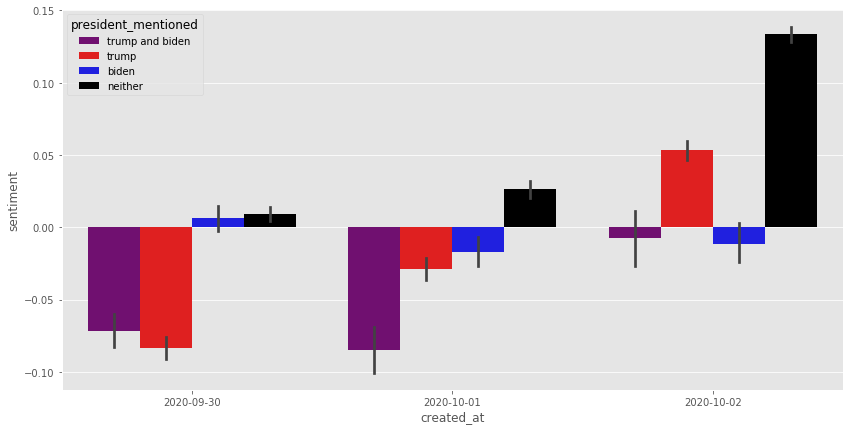

In [329]:
fig, ax = plt.subplots(figsize = (14, 7))

sns.barplot(x = 'created_at', y = 'sentiment', data=sentiment_tweets, hue='president_mentioned',palette = ['purple','red','blue','black'])


In [458]:
positive_sentiment = sentiment_tweets[sentiment_tweets.sentiment > 0]
negative_sentiment = sentiment_tweets[sentiment_tweets.sentiment < 0]

In [459]:
positive_sentiment = pd.DataFrame(positive_sentiment.groupby(['created_at', 'president_mentioned']).count()['sentiment']).reset_index()
positive_sentiment.columns = ['created_at','president_mentioned','positive_sentiment']; positive_sentiment

,created_at,president_mentioned,positive_sentiment
0,2020-09-30,biden,3254
1,2020-09-30,neither,6627
2,2020-09-30,trump,4023
3,2020-09-30,trump and biden,1355
4,2020-10-01,biden,2433
5,2020-10-01,neither,8097
6,2020-10-01,trump,4743
7,2020-10-01,trump and biden,818
8,2020-10-02,biden,1233
9,2020-10-02,neither,10994


In [460]:
negative_sentiment = pd.DataFrame(negative_sentiment.groupby(['created_at', 'president_mentioned']).count()['sentiment']).reset_index()
negative_sentiment.columns = ['created_at','president_mentioned','negative_sentiment']; negative_sentiment

,created_at,president_mentioned,negative_sentiment
0,2020-09-30,biden,2927
1,2020-09-30,neither,5628
2,2020-09-30,trump,5635
3,2020-09-30,trump and biden,1991
4,2020-10-01,biden,2453
5,2020-10-01,neither,6915
6,2020-10-01,trump,5241
7,2020-10-01,trump and biden,1234
8,2020-10-02,biden,1211
9,2020-10-02,neither,5118


In [349]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [369]:
adj_list

['corrupt']

In [461]:
sentiment_count = pd.merge(positive_sentiment, negative_sentiment)

In [473]:
sentiment_count = pd.melt(sentiment_count, ['created_at','president_mentioned'])

In [475]:
sentiment_count

,created_at,president_mentioned,variable,value
0,2020-09-30,biden,positive_sentiment,3254
1,2020-09-30,neither,positive_sentiment,6627
2,2020-09-30,trump,positive_sentiment,4023
3,2020-09-30,trump and biden,positive_sentiment,1355
4,2020-10-01,biden,positive_sentiment,2433
5,2020-10-01,neither,positive_sentiment,8097
6,2020-10-01,trump,positive_sentiment,4743
7,2020-10-01,trump and biden,positive_sentiment,818
8,2020-10-02,biden,positive_sentiment,1233
9,2020-10-02,neither,positive_sentiment,10994


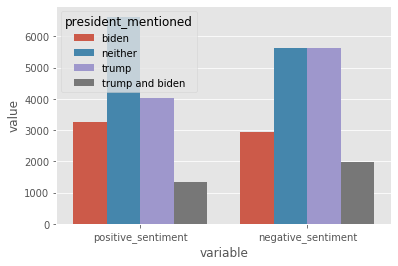

In [476]:
sns.barplot(x = sentiment_count[sentiment_count.created_at == '2020-09-30'].variable,
                y = sentiment_count[sentiment_count.created_at == '2020-09-30'].value, 
                hue = sentiment_count[sentiment_count.created_at == '2020-09-30'].president_mentioned)

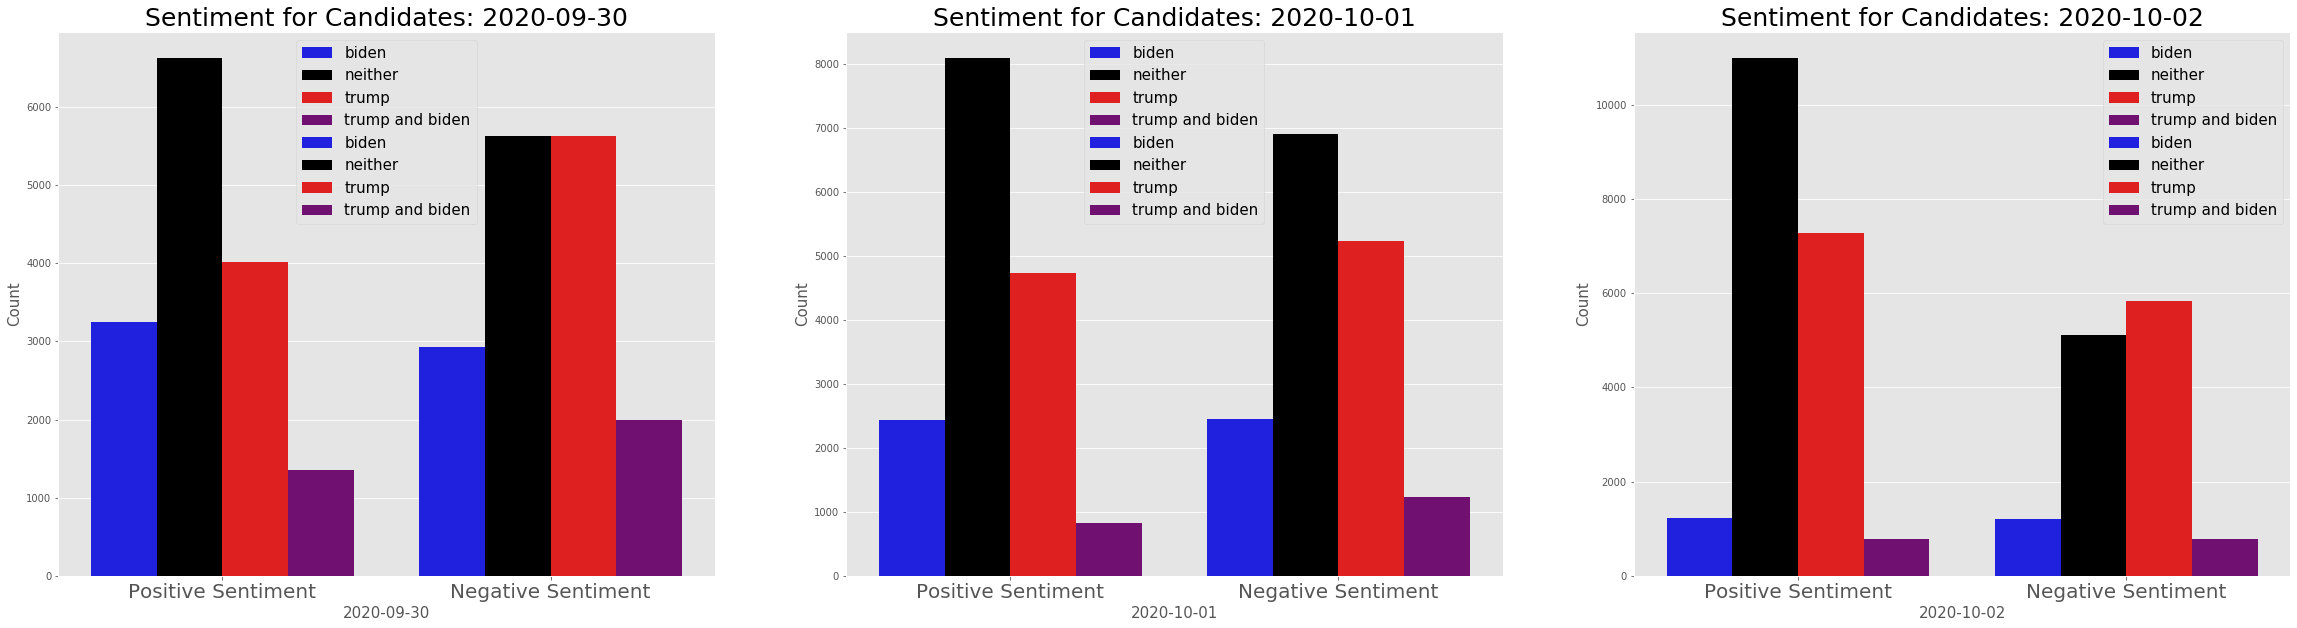

In [507]:
fig, axs = plt.subplots(1, 3, figsize = (40,10))

dates = ['2020-09-30','2020-10-01','2020-10-02']
for (ax, date) in zip(axs.flat, dates):
    sns.barplot(x = sentiment_count[sentiment_count.created_at == date].variable,
                y = sentiment_count[sentiment_count.created_at == date].value, 
                hue = sentiment_count[sentiment_count.created_at == date].president_mentioned, palette = ['blue','black','red','purple'], ax=ax)
    sns.barplot(x = sentiment_count[sentiment_count.created_at == date].variable,
                y = sentiment_count[sentiment_count.created_at == date].value, 
                hue = sentiment_count[sentiment_count.created_at == date].president_mentioned, palette = ['blue','black','red','purple'], ax=ax)
    ax.set_title('Sentiment for Candidates: {}'.format(date), fontsize = 25)
    ax.set_xlabel('{}'.format(date), fontsize = 15)
    ax.set_xticklabels(['Positive Sentiment','Negative Sentiment'],fontdict = {'fontsize':20})
    ax.set_ylabel('Count', fontsize = 15)
    ax.legend(fontsize = 15)

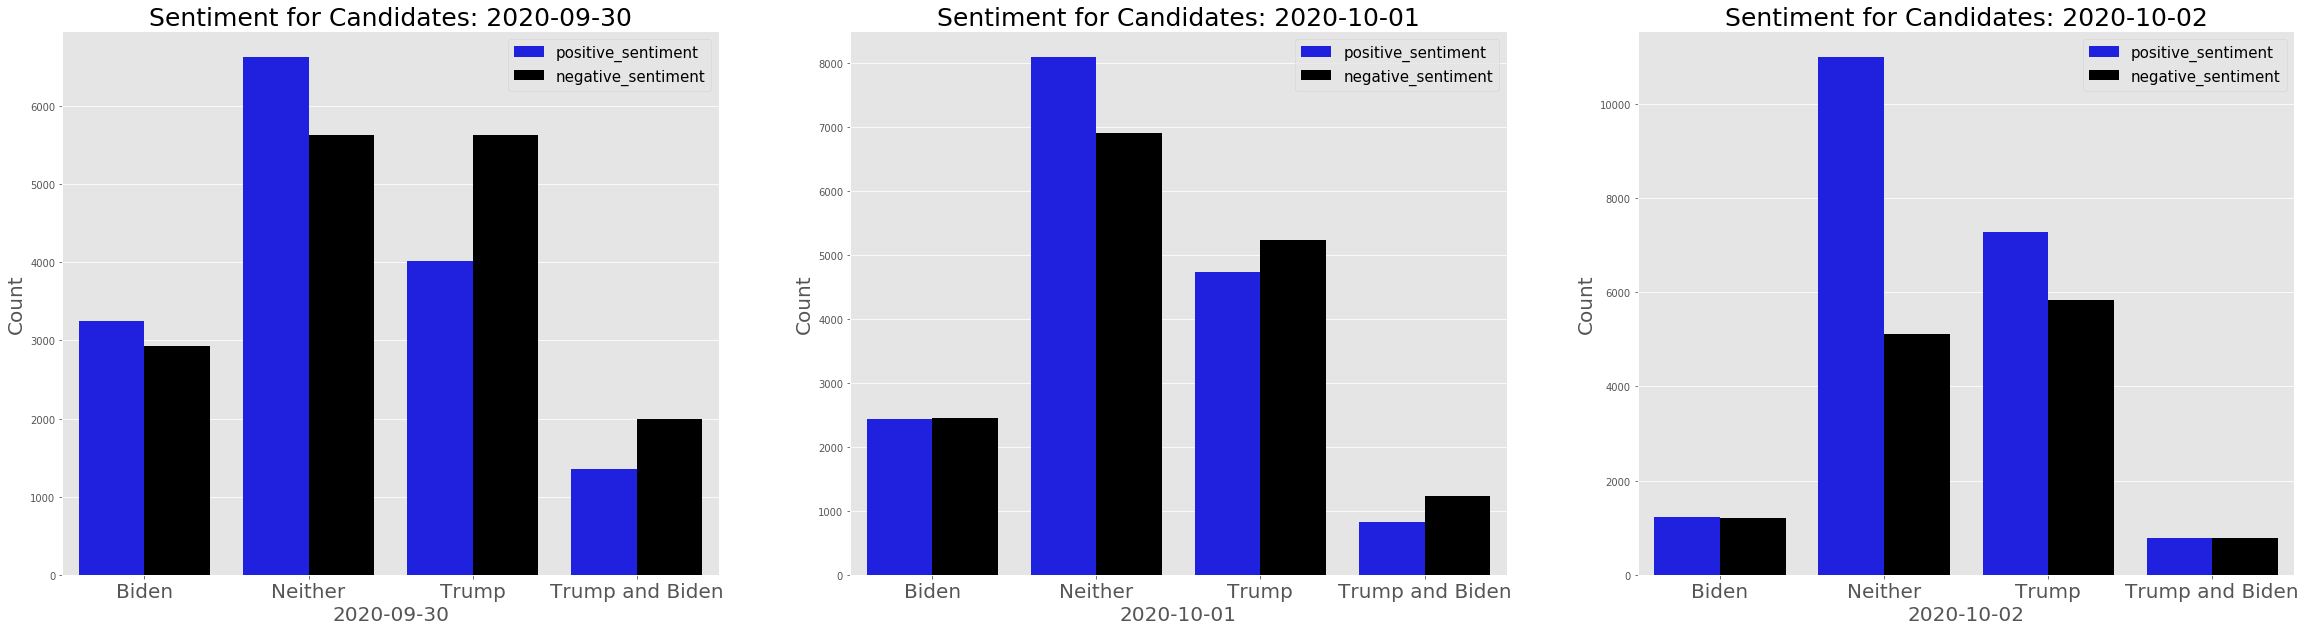

In [505]:
fig, axs = plt.subplots(1, 3, figsize = (40,10))

dates = ['2020-09-30','2020-10-01','2020-10-02']
for (ax, date) in zip(axs.flat, dates):
    sns.barplot(x = sentiment_count[sentiment_count.created_at == date].president_mentioned,
                y = sentiment_count[sentiment_count.created_at == date].value, 
                hue = sentiment_count[sentiment_count.created_at == date].variable, palette = ['blue','black'], ax=ax)
    ax.set_title('Sentiment for Candidates: {}'.format(date), fontsize = 25)
    ax.set_xlabel('{}'.format(date), fontsize = 20)
    ax.set_xticklabels(labels = ['Biden','Neither','Trump','Trump and Biden'],fontdict = {'fontsize':20})
    ax.set_ylabel('Count', fontsize = 20)
    ax.legend(fontsize = 15)